Player uses random move once if its stuck in the game

In [1]:
from tqdm import tqdm
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import datetime
import gym_2048
import gym

# torch.set_default_tensor_type('torch.cuda.FloatTensor')

from torch.utils.tensorboard import SummaryWriter

logger = False

if logger:
    log_dir = 'runs/2048_run_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    import os, shutil

    if os.path.exists(log_dir):
        shutil.rmtree(log_dir)
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    if logger: writer = SummaryWriter(log_dir)


class DQN(nn.Module):
    def __init__(self, board_size):
        super().__init__()

        self.fc1 = nn.Linear(in_features=board_size, out_features=128)
        # self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.out = nn.Linear(in_features=128, out_features=4)  # 4 actions

    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        # t = F.relu(self.fc2(t))
        t = self.out(t)
        return t


Experience = namedtuple("Experience", ('state', 'action', 'next_state', 'reward'))


class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size


class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        self.exploration_rate = None

    def get_exploration_rate(self, current_step):
        self.exploration_rate = self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)
        return self.exploration_rate


class Agent():
    def __init__(self, strategy: EpsilonGreedyStrategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
#         self.explore_count = 0
#         self.exploit_count = 0

    def print_explore_exploit_ratio(self):
        print("Explore:", self.explore_count / self.current_step, self.explore_count)
        print("Exploit:", self.exploit_count / self.current_step, self.exploit_count)

    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
#             self.explore_count += 1
            # self.print_explore_exploit_ratio()
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device)
        else:
#             self.exploit_count += 1
            # self.print_explore_exploit_ratio()
            with torch.no_grad():
                # print("================EXPLOIT================")
                # print(state)
                # print(state.shape)
                # print(policy_net(state))
                # print(policy_net(state).argmax(dim=1))
                # exit(0)
                return policy_net(state).argmax(dim=1).to(self.device)


class Gym2048EnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('2048-v0')
        self.env.reset()
        self.current_state = None
        self.done = False

    def reset(self):
        self.env.reset()
        self.current_state = None

    def close(self):
        self.env.close()

    def render(self, mode='human'):
        return self.env.render(mode)

    def num_action(self):
        return self.env.action_space.n

    def take_action(self, action):
        _, reward, self.done, _ = self.env.step(action.item())
        return [reward,self.normalize_state_reward(torch.tensor([reward], device=self.device).float())]

    def normalize_state_reward(self, val):
        zero_pos = (val == 0)
        val = torch.log2(val) / 15
        val[zero_pos] = 0
        return val

    def get_max_tile(self):
        return np.max(np.array(self.env.board))

    def get_board_size(self):
        return self.env.size ** 2
    
    def get_board(self):
        return self.env.board

    def get_state(self):
        self.current_state = self.env.board
        state = np.array(self.current_state)
        state = state.reshape(-1)  # / 4096
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        state = self.normalize_state_reward(state)
        if self.done:
            state = torch.zeros_like(state)
        return state


def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period - 1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()


def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Max Tile')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    # print("Episode", len(values), "\n", \
    #       moving_avg_period, "episode moving avg:", moving_avg[-1])


batch_size = 512
gamma = 0.9955
eps_start = 1
eps_end = 0.01
eps_decay = 0.0001
target_update = 25
memory_size = 100000
lr = 0.001
num_episodes = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)
em = Gym2048EnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_action(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(16).to(device)
target_net = DQN(16).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

maximum_tiles = []


def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    return t1, t2, t3, t4


class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = "cpu"

    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    @staticmethod
    def get_next(target_net, next_states):
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

    @staticmethod
    def get_next_actions(policy_net, next_states):
        next_actions = policy_net(next_states).argmax(axis=1).unsqueeze(-1).detach()
        return next_actions

    @staticmethod
    def get_next_state_q_values(target_net, next_states):
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        next_state_q_values = torch.zeros(batch_size, 4).to(QValues.device)
        next_state_q_values[non_final_state_locations] = target_net(non_final_states).detach()
        return next_state_q_values

    @staticmethod
    def get_next_double_dqn(policy_net, target_net, next_states):
        next_actions = QValues.get_next_actions(policy_net, next_states)
        next_q_values = QValues.get_next_state_q_values(target_net, next_states)
        next_values = next_q_values.gather(dim=1, index=next_actions).flatten().detach()
        return next_values


if logger:
    print("Log Directory:", log_dir)

load_model = True
model_dir = "saved_models"
if load_model:
    print("Loading model from:", model_dir)
    policy_net.load_state_dict(torch.load("policy_net.model"))
    target_net.load_state_dict(torch.load("target_net.model"))

cpu
Loading model from: saved_models


C:\Users\Nissan\AppData\Roaming\Python\Python37\site-packages\gym_2048\env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


In [2]:
from IPython.display import clear_output

In [3]:
import time

In [4]:
records = []

In [5]:
action_dict = {
0:"LEFT" ,
1:"UP" ,
2:"RIGHT" ,
3:"DOWN" }

In [6]:
maximum_tiles = []

In [7]:
import sys


In [8]:
from collections import deque

In [9]:
num_episodes = 100
total_timestep = 1
for episode in tqdm(range(num_episodes)):
    stuck = False
    em.reset()
    actions = deque(np.arange(50), 50)
    state = em.get_state()
    total_reward = 0
    for timestep in count():
        total_timestep += 1
        if stuck == True: 
            action = random.randrange(4)
            action = torch.tensor([action]).to(device)
            stuck = False
        else:
            action = policy_net(state).argmax(dim=1).to(device)
        actions.append(action.item()+1)
        action_str = action_dict[action.item()]
        reward = em.take_action(action)
        reward = reward[0]
        total_reward += reward
        max_tile = em.get_max_tile()
#         em.render('human')
#         time.sleep(0.5)
        next_state = em.get_state()
        records.append([episode, timestep, reward, max_tile,total_reward])
#         board=""
#         for row in em.get_board():
#             board += ' \t'.join(map(str, row))+"\n"
#         msg = "\r-Episode: {} Timestep: {} Max Tile: {}\n Score: {}\nBoard \n{}\nAction: {} ".format(episode, timestep, max_tile, total_reward, board,action_str)
#         sys.stdout.write(msg)
#         sys.stdout.flush()
#         clear_output(wait=True)
        state = next_state
        if np.sum(np.array(actions)/np.array(actions).max()) ==len(actions):
            stuck = True
        if em.done:
            maximum_tiles.append(em.get_max_tile())
            break
em.close()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.09it/s]


In [10]:
import pandas as pd

In [11]:
df = pd.DataFrame(records, columns = ['episode', 'timestep','reward','max_tile','total_reward'])

In [12]:
df

,episode,timestep,reward,max_tile,total_reward
0,0,0,4,4,4
1,0,1,0,4,4
2,0,2,0,4,4
3,0,3,0,4,4
4,0,4,4,4,8
...,...,...,...,...,...
49637,99,280,0,256,3380
49638,99,281,0,256,3380
49639,99,282,4,256,3384
49640,99,283,4,256,3388


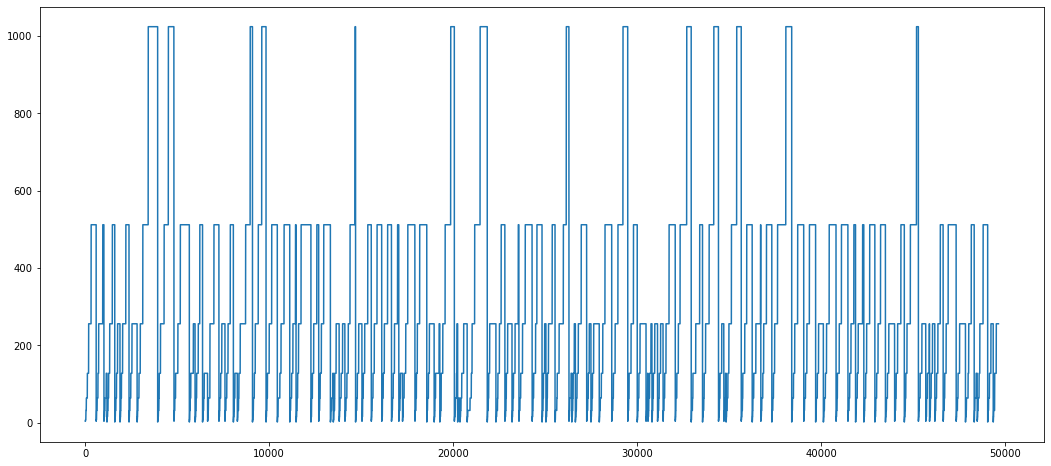

In [13]:
df.max_tile.plot(figsize=(18,8))

In [14]:
df.loc[df.groupby('episode').max_tile.idxmax()]

,episode,timestep,reward,max_tile,total_reward
310,0,310,512,512,4756
942,1,354,524,512,5284
1130,2,122,132,128,1260
1464,3,288,512,512,4480
1748,4,149,276,256,1956
...,...,...,...,...,...
48160,95,312,548,512,4760
48422,96,99,128,128,1000
48804,97,318,516,512,4788
49229,98,173,256,256,2164


In [15]:
df.loc[df.groupby('episode').max_tile.idxmax()].max_tile.value_counts(normalize=True)

512     0.46
256     0.30
1024    0.14
128     0.09
64      0.01
Name: max_tile, dtype: float64